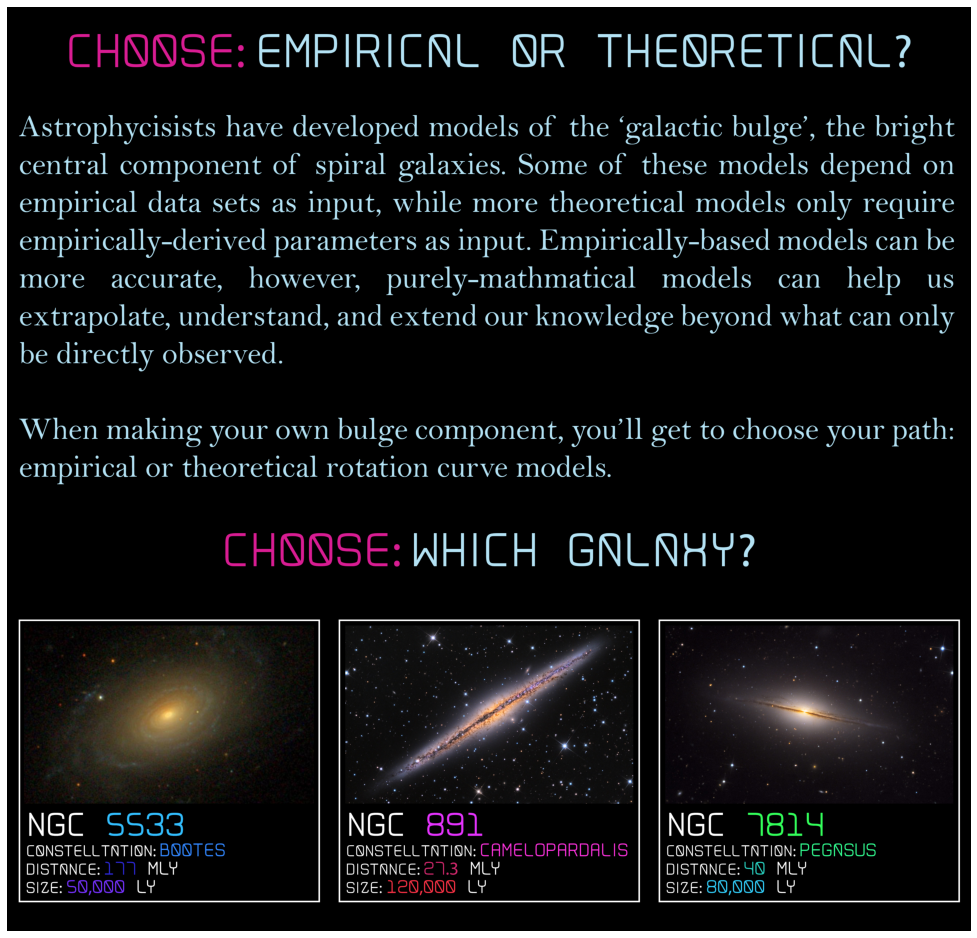

In [1]:
import time
startTime = time.time()
import matplotlib.image as mpimg
from matplotlib import pyplot as plt     # matplotlib library for plotting
img = mpimg.imread('bulge.png')
plt.figure(figsize=(20,17))                 #size of the plot
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [2]:
galaxy='5533' #change this value to select which galaxy you want

## Introduction

__What is a bulge?__ 
<br>It's that bright central part of a spiral galaxy. In shape, bulges are ellipsoidal (squishedly-spherical, to be scientific) and dense with visible matter, containing the majority of a spiral galaxy's visible matter.

The theoretical bulge model was implemented from [Noordermeer (2008)](https://doi.org/10.1111/j.1365-2966.2008.12837.x). 

***
## Equations

_Source: Noordermeer (2008)_
>__Luminosity__: <br>
    \begin{equation}
    I_b(\kappa) = I_0 \exp \left[-\left(\frac{\kappa}{r_0} \right)^{\frac{1}{n}}\right]
    \end{equation}
    <br>
>where:<br>
        $I_0$ = central surface brightness<br>
        $n$ = concentration parameter<br> 
        $r_0$ = characteristic radius (related to $r_e$)<br>
        $r_e$ = effective radius<br>
<br>
>__Gamma function__: <br>
from Noordermeer's paper<br>
    \begin{equation}
    \gamma(b_n,2n) = \frac{1}{2} \Gamma(2n)
    \end{equation}<br>
    \begin{equation}
    r_e = b_n^n r_0 b_n 
    \end{equation}<br>
from Anthony's calculations<br>
    \begin{equation}
    \gamma(n,u_e) = \frac{1}{2} \Gamma(n)
    \end{equation}<br>

>__Velocity__: <br>
    <font color="green">
    \begin{equation}
V_{B}^{2}(r) = C \int_{m=0}^{r} \left[\int_{\kappa=m}^{\infty} \frac {e^{-\left(\frac{\kappa}{r_0}\right)^{\frac{1}{n}}} \left(\frac{\kappa}{r_0}\right)^{\frac{1}{n-1}}} {\sqrt{\kappa^2-m^2}} d\kappa\right] \times \frac{m^{2}}{\sqrt{r^{2}-m^{2}e^{2}}} dm
    \end{equation}<br></font>
>where:<br>
    \begin{equation}
    C = \frac{4Gq\Upsilon_b I_0}{r_0n} \sqrt{sin^{2}i + \frac{1}{q^{2}} cos^{2}i}
    \end{equation}<br>
    \begin{equation}
    e = \sqrt{1-q^{2}}
    \end{equation}<br> 
        $\Upsilon_b$ = mass-to-light ratio<br>
        $e$ = eccentricity of the bulge<br>
        $q$ = intrinsic axis ratio<br> 
        $i$ = inclination angle<br> 
        $G$ = gravitational constant<br>
    <br>
***

In [3]:
# Importing python libraries for our calculations
import numpy as np                       # numpy library for basic calculations
import scipy.integrate as si             # for integration
import scipy.optimize as so              # for finding the root of the gamma function
import scipy.special as ss               # for the gamma function

## Parameters

### Definition

__### In Progress ###__

<b>Gravitational constant ($G$)</b>: empirical constant of the universal law of gravitation:
<br>
<br>
$
\begin{align} 
G = 4.3e^{-6} \frac{kpc(km/s)^{2}}{M_{\odot} }
\end{align}
$
<br>
<br>
(units used to match all other units) 

<b>Concentration parameter ($n$)</b>: as Noordermeer describes: _"$n$ is a concentration parameter that describes the curvature of the profile in a radiusmagnitude plot"_ (pg.1361, Noordermeer 2008). <br><br>

<b>Intrinsic axis ratio ($q$)</b>: _"q [is] the intrinsic axis ratio of the bulge isodensity surfaces"_ (pg.1360, Noordermeer 2008). This parameter describes how flat a galaxy appears. The eccentricity of the galaxy can be calculated from this parameter: $e$ = $\sqrt{1 - q^{2}}$.
<br><br>

<b>Characteristic radius ($r_0$) and Effective radius ($r_e$)</b>: as Noordermeer suggests, _"$r_0$ is the characteristic radius, which is related to the effective radius ($r_e$, the radius which encompasses 50 percent of the light) as $r_e$ = $b_{n}^{n}$ $r_0$ $b_n$ is a scaling constant that is defined such that it satisfies $\gamma$($b_n$, 2n) = $^1/_2$$\Gamma$(2n), with $\gamma$ and $\Gamma$ the incomplete and complete gamma functions, respectively."_ (pg.1361, Noordermeer 2008).<br><br>

<b>Inclination angle ($i$)</b>: the angle of the galaxy from the horizontal. 

<b>Mass-to-light ratio ($\Upsilon_b$)</b>: the ratio of how much mass there is compared to how much it is seen. 

<b>Luminosity ($L_\odot$)</b>: I'm trying to figure out where we got the 3.27e10 value from. We might have just guessed this value. Noordermeer mentions on page 5 of his 2008 paper: "The effects of the seeing on the measured bulge parameters were corrected for, using the deconvolutions from Graham (2001)."
***Found some things in our old Disk velocity calculations.***
-$\Large L = 10^{0.4(M_{\odot} - M_{absolute})}$ {1}
- Mag_absolute = -22.02, Mag_Sun = 4.42 (or Mag_sun= 4.74 according to wikipedia...)
- Mag_absolute does not match M_B (-21.22) or M_R (-22.62) from Noordermeer's papers.
    - Manually using one of these values does not result in a match, either.

<b>Central surface brightness ($I_0$)</b>: The central surface brightness was explained by Noordermeer as: <br>
_"$I_0$ and $r_0$ scaled such that all bulges have equal total luminosity ($L_b$ = 5 × $10^9$ $L_\odot$) and
effective radius ($r_e$ = 1 kpc)."_ <br>
This resulted from the gamma function the following way in our code: $I_0 = L*root^{2n}/(r_e^2*2\pi n*gamma(2n))$. <br>


($L$ is luminosity, $gamma$ is the gamma function, $root$ is the root of the gamma function, $n$ is concentration parameter, $r_e$ is the effective radius.) <br> We found an equation in this paper that was referenced by Noordermeer: [_Graham: An investigation into the prominence of spiral galaxy bulges_](https://iopscience.iop.org/article/10.1086/318767/pdf) (pg.822/eq.3): <br>


$L_{tot} = \frac{n2\pi r^2_eI_ee^b}{(b_n)^{2n}}\Gamma(2n)$, where $I_0 = I_ee^b$.The calculation resulted in a central surface brightness of about 4.10e10 (units?).

## Finding the needed values
There are seven parameters you will need to calculate the bulge of your chosen galaxy. Let's go through each of them.

1. **Msun** - the absolute magnitude of the sun in the B-band. In astronomy, magnitude is a measure of luminosity [source ?].  It is common for magnitudes to be measured in "V" or "B" bands, which refer to specific ranges of wavelengths in the electromagnetic spectrum [source ?]. For this activity, parameters for the galaxies you can choose from have been published in the B band. Thus we will need to magnitude of the sun in the B-band. (*hint: value should be positive!*)

2. **Mgalaxy** - the absolute magnitude of your galaxy in the B-band. Msun and Mgalaxy will be used to calcualte the total luminosity of your galaxy. See equation (1) in the cell above. (*hint: value should be negative, between -20 and -30!*)

3. **n** - the concentration parameter, also known as the bulge Sersic parameter, is a parameter relating to the shape (ellipsoidal or spherical) of your galaxy's bulge.

4. **re** - the effective radius of the bulge. In oversimplified terms, this is the radius (estimated) of the bulge. (*hint: value should be units of arcsec. This program will convert it from arcsec to kpc for you!*) 

5. **D** - distance from us to your galaxy. Typically measured in Million light years, or million kiloparsecs. This program takes it in kiloparsecs [kpc]. Want to know how far that is? A lightyear is nearly 6 *trillion* miles, and 1 kpc is 3.26 lightyears!

6. **q** - intrinsic axis ratio. A parameter used to model the inclination, or tilt, of your galaxy, necessary to account for in order to model the galaxy's kinematics. q will be somewhere between 0 and 1.

7. **i** - the inclination angle. Our program takes this parameter in degrees.

All of these values are available in literature made publicly-available on the internet. Will you be able to find them? This activity is intended to give you a glimpse into scholarly rotation curve work, as well as the current state of rotation curve reproducibility (and the required research thereof). Below are some hints for finding the correct parameters for your galaxy. *One last hint:* Most of the needed parameters will be found for your galaxy in source 2 of the references section of this code. Good luck!

### Assigning values:

In [ ]:
galaxy=='5533':
    #******************************************************
    #******NGC 5533 (aka UGC 9133) Bulge Parameters********
    #******************************************************
    ML = 1             #mass-to-light ratio of bulge [unitless] 
    G = 4.300e-6   #gravitaitonal constant, [kpc*(km/s)**2/Msun]

    Msun = ?           #constant, absolute magnitude of the sun in the B-band
    Mgalaxy = ?        #B-band magnitude of 5533 [unitless] 

    # parameters 
    n = ?                #concentration parameter [unitless] 
    re = ?               #effective radius, [arcsec] 
    D = ?                #distance, [Mpc] 
    
    
    q = ?              #intrinsic axis ratio [unitless] 
    i = ?              #inclination angle [degrees]
    
    # import GIPSY bulge for comparison bulge:
    #bulge = np.loadtxt('../NGC5533/ngc 5533 total/data/NGC5533-bulge_fmt.txt')
    #radii,b = bulge.
    
    #*******INTERMEDIATE CONVERSIONS**********
    
    #you've found the effective radius provided in the literature in the form of arcsecs...
    #we now need to convert it to kpc
    re= re*4.84814e-6 #arcsec to radians
    D=D*1e3 #Mpc to kpc
    re=D*np.sin(re) #use simple trigonometry to get effective radius in kpc
    print(str('The effective radius of '+galaxy +' is '+"{:.2f}".format(re)+' kpc'))

    #you've now found the absolute magnitude of the B band for NGC5533...
    #which now must be converted to total luminosity [in solar luminosities]. Note that the bands must be consistent
    L = 10**(.4*(Msun-Mgalaxy)) #calculate the total luminosity of 5533 [Lsun]
    print(str('The total Luminosity of Galaxy '+galaxy +' is '+"{:.2e}".format(L)+' solar masses'))
    
    i = i*(np.pi/180)                                  #inclination angle converted to radians

In [4]:

if galaxy=='7814':
    
    #**************************
    #******NGC 7814 Bulge****
    #*************************

    # parameters for NGC 7814 provided in this paper: https://www.aanda.org/articles/aa/pdf/2011/07/aa16634-11.pdf 
    #parameters 
    n = 10       #concentration parameter (section 3.3 par.1)
    re = 2.16    #effective radius, [kpc] (table 4)
    L = 7e10     #bulge luminosity, [Lsun] (table 4)
    ML = .71    #mass-to-light ratio of bulge given DM halo (table 5)
    q = 0.61     #intrinsic axis ratio (table 4)
    i=90         #inclination angle [degrees] (table 1)

    #import GIPSY bulge for comparison bulge:
    #bulge = np.loadtxt('../testing/7814reallybulge.dat')
    prefactor=4.98 #from our fitting with NGC 7814
    #radii,k,b = bulge.T #ignore k

elif galaxy=='891':
    
    #**************************
    #******NGC 891 Bulge****
    #*************************

    # parameters for NGC 891 provided in this paper: https://www.aanda.org/articles/aa/pdf/2011/07/aa16634-11.pdf 
    #parameters 
    n = 10        #concentration parameter (section 3.3 par.1)
    re = 1.8      #effective radius, [kpc] (table 4)
    L = 2.2e10    #bulge luminosity, [Lsun] (table 4)
    ML = 1.63    #mass-to-light ratio of bulge given DM halo (table 5)
    q = 0.68      #intrinsic axis ratio (table 4)
    i=89          #inclination angle [degrees] (table 1)

    #import GIPSY bulge for comparison bulge:
    #bulge = np.loadtxt('../NGC891/891_bulge.dat')
    prefactor=1 #from our fitting with NGC 891???
    #radii,k,b = bulge.T #ignore k

elif galaxy=='5533':
    #**************************
    #******NGC 5533 Bulge******
    #**************************
    # Also known as UGC 9133
    Msun_B = 5.44          #constant, absolute magnitude of the sun in the B-band [source 4, Abstract]

    # parameters 
    n = 2.7                #concentration parameter [unitless] (Source 2)
    re=9.9                 #effective radius, [arcsec] (Source 2, table A4)
    D=54.3                 #distance, [Mpc] (Source 2, Table 1)
    
    
    M_abs_5533 = -21.22    #B-band magnitude of 5533 [unitless] (Source 2, Table 1)
    q = 0.33               #intrinsic axis ratio [unitless] (Source 1, Table 1)
    ML = 2.8              #mass-to-light ratio of bulge [unitless] (Source: 1, Table 1 for q = 0.33)
    i = 52                 #inclination angle [degrees] (Source 2, Table A2)
    
    # import GIPSY bulge for comparison bulge:
    #bulge = np.loadtxt('../NGC5533/ngc 5533 total/data/NGC5533-bulge_fmt.txt')
    prefactor = 1 #this is a trace...
    #radii,b = bulge.
    
    
    #you've found the effective radius provided in the literature in the form of arcsecs...
    #we now need to convert it to kpc
    re= re*4.84814e-6 #arcsec to radians
    D=D*1e3 #Mpc to kpc
    re=D*np.sin(re) #use simple trigonometry to get effective radius in kpc
    print(str('The cutoff radius of '+galaxy +' is '+"{:.2f}".format(re)+' kpc'))

    #you've now found the absolute magnitude of the B band for NGC5533...
    #which now must be converted to total luminosity [in solar luminosities]. Note that the bands must be consistent
    L = 10**(.4*(Msun_B-M_abs_5533)) #calculate the total luminosity of 5533 [Lsun]
    print(str('The total Luminosity of Galaxy '+galaxy +' is '+"{:.2e}".format(L)+' solar masses'))
    
    i = i*(np.pi/180)                                  #inclination angle converted to radians
else:
    print(str('Sorry, we do not have data for galaxy NGC '+ galaxy))
    raise SystemExit("Stop right there!")


The cutoff radius of 5533 is 2.61 kpc
The total Luminosity of Galaxy 5533 is 4.61e+10 solar masses


## Gamma function

In [5]:
gammafunction = lambda x: ss.gammainc(2*n,x)*ss.gamma(2*n)-0.5*ss.gamma(2*n)
root = so.brentq(gammafunction,0,500000,rtol=0.000001,maxiter=100) #come within 1% of exact root within 100 iterations

## Define values

In [6]:
I0 = L*root**(2*n)/(re**2*2*np.pi*n*ss.gamma(2*n))
r0 = re/root**n

## Integrand 1

In [7]:
integrand1 = lambda x,m: np.exp(-np.power(x/r0, (1/n)))*np.power(x/r0, 1/n-1)/(np.sqrt(x**2-m**2))

## Integration

In [8]:
f = lambda m: si.quad(integrand1, m, np.inf,args=(m,))[0]
fv = np.vectorize(f)

## Define more values

In [9]:
C = (4*G*q*ML*I0)/(r0*np.float(n))*(np.sqrt((np.sin(i)**2)+(1/(q**2))*(np.cos(i)**2)))
e2 = 1-(q**2)


## Integrand 2

In [10]:
g = lambda m,r: C*f(m)*(m**2)/(np.sqrt((r**2)-((m**2)*(e2))))

## Integrate to get velocity squared

In [11]:
velsq = lambda r: si.quad(g, 0, r, args=(r,))[0]
velsqv = np.vectorize(velsq)

## Calculate velocity

In [12]:
radii=np.linspace(0.01,20,100)
vbulge = np.sqrt(velsqv(radii))

<ipython-input-8-5503bd1d91d7>:1: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  f = lambda m: si.quad(integrand1, m, np.inf,args=(m,))[0]
<ipython-input-8-5503bd1d91d7>:1: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  f = lambda m: si.quad(integrand1, m, np.inf,args=(m,))[0]


## Plot the velocity curve for the bulge

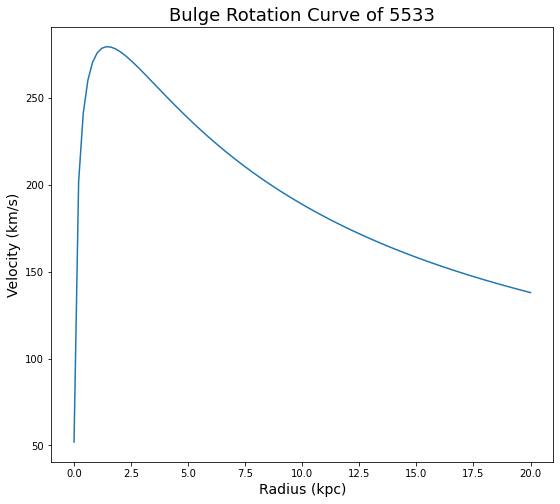

In [13]:
plt.figure(figsize=(9.0,8.0))                                     # size of the plot
plt.plot(radii, vbulge, linestyle='solid', label='Velocity(r)')  # x and y values of the plot          
plt.title(str('Bulge Rotation Curve of '+galaxy), fontsize=18)                    # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=14)                           # labeling the x-axis
plt.ylabel('Velocity (km/s)', fontsize=14)                        # labeling the y-axis
plt.savefig('bulge_theoretical.png')                              # saving the figure in a .png file

## Questions

##### Does the bulge have any effect on the rotation of the stars at 35 kpc?

##### What effect does changing the concentration parameter, $n$ to a lower number will have on the rotation curve?

##### Some questions about the curve

## References

1. Noordermeer, Edo. __“The Rotation Curves of Flattened Sérsic Bulges.”__ _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (October 22, 2008): 1359–64. https://doi.org/10.1111/j.1365-2966.2008.12837.x. 

2. Noordermeer, E., and J. M. Van Der Hulst. __“The Stellar Mass Distribution in Early-Type Disc Galaxies: Surface Photometry and Bulge–Disc Decompositions.”__ _Monthly Notices of the Royal Astronomical Society_ 376, no. 4 (April 2007): 1480–1512. https://doi.org/10.1111/j.1365-2966.2007.11532.x. 

3. Fraternali F, Sancisi R, Kamphuis P. __"A tale of two galaxies: light and mass in NGC 891 and NGC 7814."__ _Astronomy & Astrophysics_. 2011;531:A64. https://doi:10.1051/0004-6361/201116634.

4. https://doi.org/10.3847/1538-4365/aabfdf




In [14]:
executionTime = (time.time() - startTime)
print(f'Execution time: {executionTime:.2f} seconds')

Execution time: 1.81 minutes


In [15]:
import tkinter

def label1(root):
    label = tkinter.Label(root, text = "correct")
    label.pack()

def Window2():
    window1 = tkinter.Tk()
    window1.title("start")
    label = tkinter.Label(window1, text= "how do you spell this Sh--ld")
    label.pack()
    points = 0
    i = points + 1
    button = tkinter.Button(window1, text = "ou", command = lambda root = window1: label1(root))
    button.pack()



window = tkinter.Tk()
window.title("menu")

button = tkinter.Button(window, text = "start", command = Window2)
button.pack()

window.mainloop()